# Classificação de Imagens Usando Modelos de Redes Neurais Convolucionais com PyTorch




### **Objetivo**

O objetivo deste projeto é introduzir o uso de redes neurais para classificação de imagens. Esse projeto explora três abordagens:

1. Treinamento de uma rede do zero.
2. Uso de uma rede pré-treinada sem fine-tuning.
3. Fine-tuning de uma rede pré-treinada.

### **Modelos e Dataset:**

* O dataset utilizado é o [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)

* O modelo utilizado é: [ResNet](https://pytorch.org/vision/main/models/resnet.html)

### **Estrutura do Projeto**

1. Download do dataset
2. Plotagem de imagens que serão usadas
3. Modelos, critérios e otimizadores das redes
4. Treino das redes
5. Plotagem das métricas de avaliação das redes

# 1. Download do dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

Importando as bibliotecas usada no projeto:

* [os](https://docs.python.org/3/library/os.html): Biblioteca para interagir com o sistema operacional (manipulação de arquivos e diretórios).
* [torch](https://pytorch.org/docs/stable/index.html): Usado para construir e treinar redes neurais, fornecendo operações de tensores, autograd e otimização para aprendizado profundo.
* [torch.nn](https://pytorch.org/docs/stable/nn.html): Submódulo do PyTorch que contém camadas, funções de ativação, e perda, facilitando a criação de arquiteturas de redes neurais.
* [torch.optim](https://pytorch.org/docs/stable/optim.html): Oferece uma série de algoritmos de otimização, como SGD e Adam, para atualizar os pesos das redes neurais durante o treinamento.
* [torchvision](https://pytorch.org/vision/stable/index.html): Contém utilitários para processamento de dados de visão computacional, incluindo transformações de imagens, datasets como CIFAR-10 e modelos pré-treinados.
* [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html): Fornece uma coleção de transformações para realizar operações de pré-processamento de imagens, como redimensionamento, normalização e rotação.
* [sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics): Oferece funções para calcular métricas de avaliação como acurácia, precisão, recall e F1-score, usadas para medir a performance do modelo.
* [seaborn](https://seaborn.pydata.org/index.html): Biblioteca para visualização de dados que facilita a criação de gráficos estatísticos atrativos e informativos.
* [matplotlib.pyplot](https://matplotlib.org/stable/users/index.html): Biblioteca usada para criar gráficos, permitindo visualização de dados e resultados de forma intuitiva.
* [tqdm](https://tqdm.github.io/): Biblioteca que fornece uma barra de progresso em loops, facilitando o monitoramento de processos demorados, como o treinamento de redes neurais.

In [5]:
# Verifica se uma GPU está disponível
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print("Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Usar CPU
    print("Usando CPU")

Usando CPU


Processo que verifica se o uso de GPU está disponível para o treinamento do modelo.

In [6]:
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
batch_size_train = 128
batch_size_test = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #expande e realiza um corte na imagem
    transforms.RandomHorizontalFlip(), # Realiza um flip horizontal aleatório na imagem (espelhamento em torno do eixo vertical).
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

# carregando os dados de treino
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size_train, shuffle=True, num_workers=8)

# carregando os dados de teste
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size_test, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


Download do dataset e definição de como os dados serão carregados e transformados.

1. Normalização:
  * `mean`: Definição de valor médio para cada canal de cor (R, G, B) das imagens.
  * `std`: Desvio padrão.

2. Tamnho dos lotes de dados:
  * `batch_size`: Define o tamanho do lote de dados (imagens), ou seja, quantas imagens serão processadas por vez (época).

3. Transformação para os dados de treino:
  * `RandomCrop`: Aplica um corte aleatório de tamanho 32x32 na imagem, com um preenchimento (padding) de 4 pixels ao redor da imagem original.
  * `RandomHorizontalFlip`: Faz um espelhamento horizontal aleatório, permitindo que a rede veja variações da imagem durante o treinamento (data augmentation).
  * `ToTensor`: Converte a imagem de um array NumPy para um tensor do PyTorch, que é o formato usado pela rede neural.
  * `Normalize`: Normaliza os valores dos pixels da imagem para que eles tenham média 0.5 e desvio padrão 0.5, o que ajuda a estabilizar o treinamento.

  São usados parametros diferentes no transforms, pois o **treino** do modelo tem a necessidade de ver variações diferentes das imagens para não criar um hábito de vício durante o treinamento, já o **teste**, recebe parametros iguais para estabilizar e dar precisão ao modelo.

4. Carregando o dataset:
  * `set`: Carrega o dataset CIFAR-10. Baixando e salvando na pasta './data'
  * `loader`: misturando (shuffle) as imagens a cada época. O parâmetro 'num_workers' define o número de processos paralelos para carregar os dados.

# 2. Plotagem de imagens que serão usadas

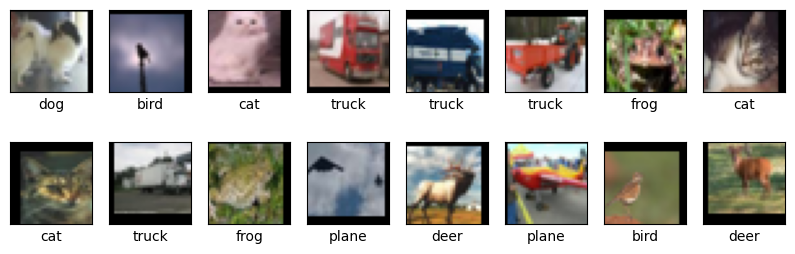

In [7]:
# Função para desfazer a normalização
def unnormalize(img, mean, std):
    img = img.clone()  # Faz uma cópia do tensor para evitar mudanças na imagem original
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # desfaz normalização: (img * std) + mean
    return img

# Obtendo imagens de treinamento aleatórias
dataiter = iter(trainloader)  # iterador para o DataLoader
images, labels = next(dataiter)  # obter um batch de imagens e rótulos

# Definir as classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualizando algumas das imagens do dataset de treino
plt.figure(figsize=[10, 10])
for i in range(16):  # para as primeiras 16 imagens
    plt.subplot(6, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Permutar a imagem de (3, 32, 32) para (32, 32, 3)
    img = unnormalize(images[i], mean, std).permute(1, 2, 0)
    
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(classes[labels[i].item()])

plt.show()

Mostra as primeiras 16 imagens do conjunto de imagens de treino, além do nome da classe em que ela está classificada.

# 3. Modelos, critérios e otimizadores das redes

### **Treinamento de uma rede do zero**

In [8]:
model_zero = torchvision.models.resnet18(weights=None)  # Treinamento do zero
model_zero.fc = nn.Linear(model_zero.fc.in_features, 10)  # Modifica a última camada para 10 classes

O parametro 'weights=None' faz com que o modelo não tenha pesos e sejá treinado do zero.

### **Uso de uma rede pré-treinada sem fine-tuning**

In [9]:
model_no_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)  # Rede pré-treinada

for param in model_no_ft.parameters():
    param.requires_grad = False  # Congelar as camadas

model_no_ft.fc = nn.Linear(model_no_ft.fc.in_features, 10)  # Modifica a última camada para 10 classes

### **Fine-tuning de uma rede pré-treinada**

In [10]:
# Não congela as camadas, permitindo o fine-tuning de toda a rede
model_on_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) #ResNet18 já pré-treinada
model_on_ft.fc = nn.Linear(model_on_ft.fc.in_features, 10) # Modifica a última camada para 10 classes (CIFAR-10)

Os pesos dos modelos pré-treinados são do dataset [IMAGENET]().

#### **Criterion e optimizer**

In [11]:
criterion = nn.CrossEntropyLoss() # loss funciton

A variável criterion define a loss function que será usada para o treino do modelo.

In [12]:
optimizer_zero = optim.Adam(model_zero.parameters(), lr=0.001) # modelo otimizador

In [13]:
optimizer_no_ft = optim.Adam(model_no_ft.parameters(), lr=0.001) # modelo otimizador

In [14]:
optimizer_on_ft = optim.Adam(model_on_ft.parameters(), lr=0.001) # modelo otimizador

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html): modelo de otimização.
* lr (learning rate): taxa de aprendizado do otimizador. Quanto maior, mais rápido e menos preciso.

# 4. Treino das redes

In [15]:
def treino_modelo(modelo, otimizador, epocas):
    modelo.train()  # coloca o modelo em modo de treinamento
    history = {'train_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

    for epoch in range(epocas):
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        # Loop de treino por batch
        for inputs, labels in tqdm(trainloader):
            otimizador.zero_grad()  # zera os gradientes acumulados

            outputs = modelo(inputs)  # forward pass: obtem as predições
            loss = criterion(outputs, labels)  # calcula a perda
            loss.backward()  # backward pass: calcula os gradientes
            otimizador.step()  # atualiza os pesos

            running_loss += loss.item()  # acumula a perda

            # Armazena os rótulos e predições para calcular métricas
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calcula a perda média na época
        epoch_loss = running_loss / len(trainloader)
        history['train_loss'].append(epoch_loss)

        # Calcula as métricas de acurácia, precisão, recall e F1-Score
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Armazena as métricas
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1_score'].append(f1)

        print(f'Epoch [{epoch + 1}/{epocas}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    return history

Esse código define uma função chamada `treino_modelo` que treina uma rede neural em PyTorch. Aqui está uma explicação detalhada de cada parte do código:

### Função `treino_modelo`

#### Parâmetros:
- `modelo`: a rede neural a ser treinada.
- `otimizador`: o otimizador usado para ajustar os pesos do modelo (ex: `SGD`, `Adam`).
- `epocas`: o número de épocas de treinamento, que representa quantas vezes o modelo verá o conjunto de dados completo.

#### Estrutura Geral:
1. **`modelo.train()`**: Coloca o modelo em modo de treinamento. Isso é importante porque alguns componentes do modelo, como camadas de dropout ou batch normalization, se comportam de maneira diferente durante o treino e a avaliação.

2. **`history`**: Dicionário usado para armazenar os valores de perda e métricas calculadas ao longo das épocas (loss, acurácia, precisão, recall, F1-Score).

### Loop de Treinamento (Por Época)

#### Para cada época:
1. **`running_loss`**: Acumulador para a soma das perdas em cada batch da época.
2. **`all_labels`** e **`all_predictions`**: Listas que armazenam os rótulos verdadeiros e as previsões para cada batch da época. Essas listas são usadas posteriormente para calcular métricas como acurácia e F1-Score.

#### Loop de Treinamento (Por Batch):
Para cada lote de dados (batch) no `trainloader`, as seguintes etapas são executadas:

1. **`otimizador.zero_grad()`**: Zera os gradientes dos parâmetros do modelo. Isso é necessário porque, por padrão, PyTorch acumula os gradientes em vez de sobrescrevê-los.

2. **`outputs = modelo(inputs)`**: Faz a previsão do modelo para o batch de entradas (`inputs`).

3. **`loss = criterion(outputs, labels)`**: Calcula a perda comparando as previsões (`outputs`) com os rótulos reais (`labels`). O `criterion` (não mostrado aqui) deve ser definido antes e pode ser uma função como `CrossEntropyLoss`.

4. **`loss.backward()`**: Calcula os gradientes da perda em relação aos parâmetros do modelo (backpropagation).

5. **`otimizador.step()`**: Atualiza os pesos do modelo com base nos gradientes calculados.

6. **`running_loss += loss.item()`**: Acumula o valor da perda do batch na variável `running_loss`.

7. **`predicted = torch.max(outputs, 1)`**: Obtém as previsões mais prováveis a partir dos `outputs`. O `torch.max` retorna o índice da classe com maior valor de probabilidade.

8. **Armazenamento de resultados**: Os rótulos verdadeiros (`labels`) e as previsões (`predicted`) são convertidos para arrays NumPy e adicionados às listas `all_labels` e `all_predictions`.

### Fim da Época:

1. **Cálculo da perda média**:
   - A perda acumulada da época (`running_loss`) é dividida pelo número de batches para obter a perda média da época, que é armazenada no histórico (`history['train_loss']`).

2. **Cálculo de Métricas**:
   - **Acurácia** (`accuracy_score`): Proporção de previsões corretas.
   - **Precisão** (`precision_score`): Proporção de previsões corretas entre as positivas.
   - **Recall** (`recall_score`): Proporção de verdadeiros positivos identificados corretamente.
   - **F1-Score** (`f1_score`): Média harmônica entre precisão e recall, uma métrica de desempenho geral.
   
   Todas as métricas são calculadas com `average='weighted'`, o que significa que elas são ponderadas pelo suporte (número de amostras de cada classe).

3. **Impressão dos resultados**: Após cada época, os valores da perda, acurácia, precisão, recall e F1-Score são impressos.

4. **Armazenamento das métricas**: Todas as métricas calculadas (acurácia, precisão, recall, F1-Score) são adicionadas ao dicionário `history`.

### Retorno:
- A função retorna o dicionário `history`, que contém os valores da perda e as métricas para cada época. Isso pode ser útil para plotar gráficos de desempenho ao final do treinamento.

### Resumo:
Essa função implementa um loop de treinamento clássico de uma rede neural em PyTorch, calculando e armazenando tanto a perda quanto as métricas de classificação (acurácia, precisão, recall e F1-Score) após cada época. Ela usa o otimizador para ajustar os pesos do modelo, e o `trainloader` para carregar os dados em batches.

### **Treino rede do zero**

In [16]:
history_zero = treino_modelo(model_zero, optimizer_zero, 10)

100%|██████████| 391/391 [05:51<00:00,  1.11it/s]


Epoch [1/10] - Loss: 1.5434, Accuracy: 0.4363, Precision: 0.4310, Recall: 0.4363, F1-Score: 0.4326


100%|██████████| 391/391 [06:00<00:00,  1.08it/s]


Epoch [2/10] - Loss: 1.1832, Accuracy: 0.5764, Precision: 0.5734, Recall: 0.5764, F1-Score: 0.5747


100%|██████████| 391/391 [05:56<00:00,  1.10it/s]


Epoch [3/10] - Loss: 1.0214, Accuracy: 0.6379, Precision: 0.6359, Recall: 0.6379, F1-Score: 0.6367


100%|██████████| 391/391 [05:48<00:00,  1.12it/s]


Epoch [4/10] - Loss: 0.9280, Accuracy: 0.6738, Precision: 0.6720, Recall: 0.6738, F1-Score: 0.6728


100%|██████████| 391/391 [05:50<00:00,  1.12it/s]


Epoch [5/10] - Loss: 0.8552, Accuracy: 0.6973, Precision: 0.6958, Recall: 0.6973, F1-Score: 0.6964


100%|██████████| 391/391 [05:37<00:00,  1.16it/s]


Epoch [6/10] - Loss: 0.7932, Accuracy: 0.7226, Precision: 0.7218, Recall: 0.7226, F1-Score: 0.7221


100%|██████████| 391/391 [05:31<00:00,  1.18it/s]


Epoch [7/10] - Loss: 0.7378, Accuracy: 0.7417, Precision: 0.7408, Recall: 0.7417, F1-Score: 0.7411


100%|██████████| 391/391 [05:27<00:00,  1.20it/s]


Epoch [8/10] - Loss: 0.7075, Accuracy: 0.7531, Precision: 0.7525, Recall: 0.7531, F1-Score: 0.7527


100%|██████████| 391/391 [05:26<00:00,  1.20it/s]


Epoch [9/10] - Loss: 0.6632, Accuracy: 0.7691, Precision: 0.7684, Recall: 0.7691, F1-Score: 0.7686


100%|██████████| 391/391 [05:27<00:00,  1.19it/s]


Epoch [10/10] - Loss: 0.6417, Accuracy: 0.7756, Precision: 0.7750, Recall: 0.7756, F1-Score: 0.7752


#### Salvando os pesos do modelo treinado do zero.

In [17]:
# Caminho para o diretório atual
diretorio_atual = os.getcwd()

# Diretório pai
diretorio_pai = os.path.dirname(diretorio_atual)

# Construindo o caminho
pasta_modelos = os.path.join(diretorio_pai, 'models_weights')

# Salvar os pesos do modelo na pasta
caminho_pesos = os.path.join(pasta_modelos, 'resnet18_weigths.pth')
torch.save(model_zero.state_dict(), caminho_pesos)

### **Treino rede sem fine_turning**

In [18]:
history_no_ft = treino_modelo(model_no_ft, optimizer_no_ft, 10)

100%|██████████| 391/391 [01:11<00:00,  5.46it/s]


Epoch [1/10] - Loss: 1.8643, Accuracy: 0.3406, Precision: 0.3389, Recall: 0.3406, F1-Score: 0.3393


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


Epoch [2/10] - Loss: 1.7156, Accuracy: 0.3973, Precision: 0.3945, Recall: 0.3973, F1-Score: 0.3952


100%|██████████| 391/391 [01:10<00:00,  5.55it/s]


Epoch [3/10] - Loss: 1.6959, Accuracy: 0.4055, Precision: 0.4025, Recall: 0.4055, F1-Score: 0.4032


100%|██████████| 391/391 [01:10<00:00,  5.54it/s]


Epoch [4/10] - Loss: 1.6872, Accuracy: 0.4076, Precision: 0.4046, Recall: 0.4076, F1-Score: 0.4054


100%|██████████| 391/391 [01:11<00:00,  5.51it/s]


Epoch [5/10] - Loss: 1.6756, Accuracy: 0.4134, Precision: 0.4108, Recall: 0.4134, F1-Score: 0.4114


100%|██████████| 391/391 [01:11<00:00,  5.47it/s]


Epoch [6/10] - Loss: 1.6769, Accuracy: 0.4143, Precision: 0.4112, Recall: 0.4143, F1-Score: 0.4120


100%|██████████| 391/391 [01:11<00:00,  5.48it/s]


Epoch [7/10] - Loss: 1.6719, Accuracy: 0.4144, Precision: 0.4114, Recall: 0.4144, F1-Score: 0.4123


100%|██████████| 391/391 [01:11<00:00,  5.49it/s]


Epoch [8/10] - Loss: 1.6748, Accuracy: 0.4155, Precision: 0.4127, Recall: 0.4155, F1-Score: 0.4134


100%|██████████| 391/391 [01:11<00:00,  5.48it/s]


Epoch [9/10] - Loss: 1.6690, Accuracy: 0.4177, Precision: 0.4147, Recall: 0.4177, F1-Score: 0.4154


100%|██████████| 391/391 [01:11<00:00,  5.48it/s]


Epoch [10/10] - Loss: 1.6713, Accuracy: 0.4142, Precision: 0.4112, Recall: 0.4142, F1-Score: 0.4118


### **Treino rede com fine-turning**

In [19]:
history_on_ft = treino_modelo(model_on_ft, optimizer_on_ft, 10)

100%|██████████| 391/391 [05:41<00:00,  1.14it/s]


Epoch [1/10] - Loss: 1.0374, Accuracy: 0.6450, Precision: 0.6447, Recall: 0.6450, F1-Score: 0.6448


100%|██████████| 391/391 [05:33<00:00,  1.17it/s]


Epoch [2/10] - Loss: 0.7449, Accuracy: 0.7463, Precision: 0.7454, Recall: 0.7463, F1-Score: 0.7458


100%|██████████| 391/391 [05:40<00:00,  1.15it/s]


Epoch [3/10] - Loss: 0.6581, Accuracy: 0.7753, Precision: 0.7746, Recall: 0.7753, F1-Score: 0.7748


100%|██████████| 391/391 [05:49<00:00,  1.12it/s]


Epoch [4/10] - Loss: 0.5941, Accuracy: 0.7965, Precision: 0.7958, Recall: 0.7965, F1-Score: 0.7960


100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


Epoch [5/10] - Loss: 0.5520, Accuracy: 0.8095, Precision: 0.8089, Recall: 0.8095, F1-Score: 0.8091


100%|██████████| 391/391 [05:56<00:00,  1.10it/s]


Epoch [6/10] - Loss: 0.5254, Accuracy: 0.8192, Precision: 0.8188, Recall: 0.8192, F1-Score: 0.8190


100%|██████████| 391/391 [05:47<00:00,  1.13it/s]


Epoch [7/10] - Loss: 0.5008, Accuracy: 0.8279, Precision: 0.8275, Recall: 0.8279, F1-Score: 0.8276


100%|██████████| 391/391 [05:38<00:00,  1.15it/s]


Epoch [8/10] - Loss: 0.4766, Accuracy: 0.8362, Precision: 0.8360, Recall: 0.8362, F1-Score: 0.8361


100%|██████████| 391/391 [05:42<00:00,  1.14it/s]


Epoch [9/10] - Loss: 0.4484, Accuracy: 0.8459, Precision: 0.8456, Recall: 0.8459, F1-Score: 0.8456


100%|██████████| 391/391 [05:43<00:00,  1.14it/s]


Epoch [10/10] - Loss: 0.4501, Accuracy: 0.8454, Precision: 0.8451, Recall: 0.8454, F1-Score: 0.8452


# 5. Plotagem das métricas de avaliação das redes

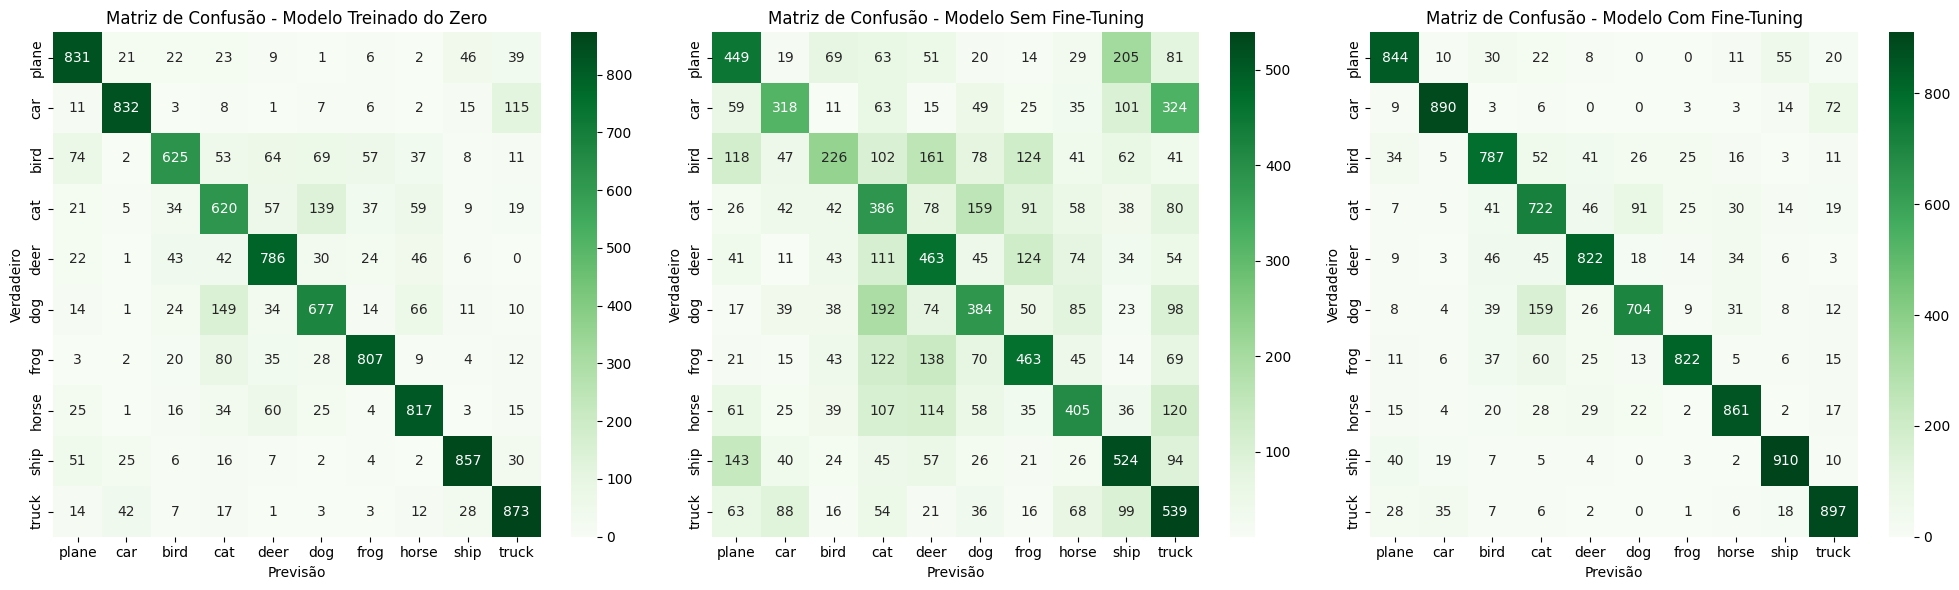

In [22]:
def matriz_confusao_modelo(modelo, titulo_grafico, ax):
    # Inicializar listas para armazenar labels verdadeiros e previsões
    all_labels = []
    all_predictions = []

    # Avaliar o modelo e coletar as previsões
    with torch.no_grad():  # Desativa o cálculo de gradientes durante a avaliação
        for images, labels in testloader:
            outputs = modelo(images)
            _, predictions = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())  # Coletar rótulos reais
            all_predictions.extend(predictions.cpu().numpy())  # Coletar previsões

    # Gerar matriz de confusão
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Plotar a matriz de confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', ax=ax, xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Previsão')
    ax.set_ylabel('Verdadeiro')
    ax.set_title('Matriz de Confusão - ' + titulo_grafico)

# Criar a figura e os subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 linha e 3 colunas

# Chamando a função para os três modelos treinados
matriz_confusao_modelo(model_zero, 'Modelo Treinado do Zero', axs[0])
matriz_confusao_modelo(model_no_ft, 'Modelo Sem Fine-Tuning', axs[1])
matriz_confusao_modelo(model_on_ft, 'Modelo Com Fine-Tuning', axs[2])

# Ajustar o layout dos gráficos para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()


- **Precisão(Precision)**: Indica a proporção de previsões corretas entre as classes. Por exemplo, se você tiver uma precisão de 0,80 para a classe 0, isso significa que 80% das previsões feitas para essa classe foram corretas.

$$\text{Precision} = \frac{TP}{TP + FP}$$


- **Revocação(Recall)**: Indica a proporção de verdadeiros positivos entre todos os exemplos positivos. Se você tiver uma revocação de 0,75 para a classe 1, isso significa que 75% dos exemplos positivos para essa classe foram corretamente identificados.

$$\text{Recall} = \frac{TP}{TP + FN}$$


- **F1-Score**: A média harmônica entre precisão e revocação. É especialmente útil quando você tem classes desbalanceadas.

$$\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$


- **Acurácia (Accuracy)**: A proporção de previsões corretas entre todas as previsões feitas.

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$


Onde:
- $(TP) = True Positives (Verdadeiros Positivos)$
- $(FN) = False Negatives (Falsos Negativos)$
- $(FP) = False Positives (Falsos Positivos)$

## Plotagem das métricas de desempenho

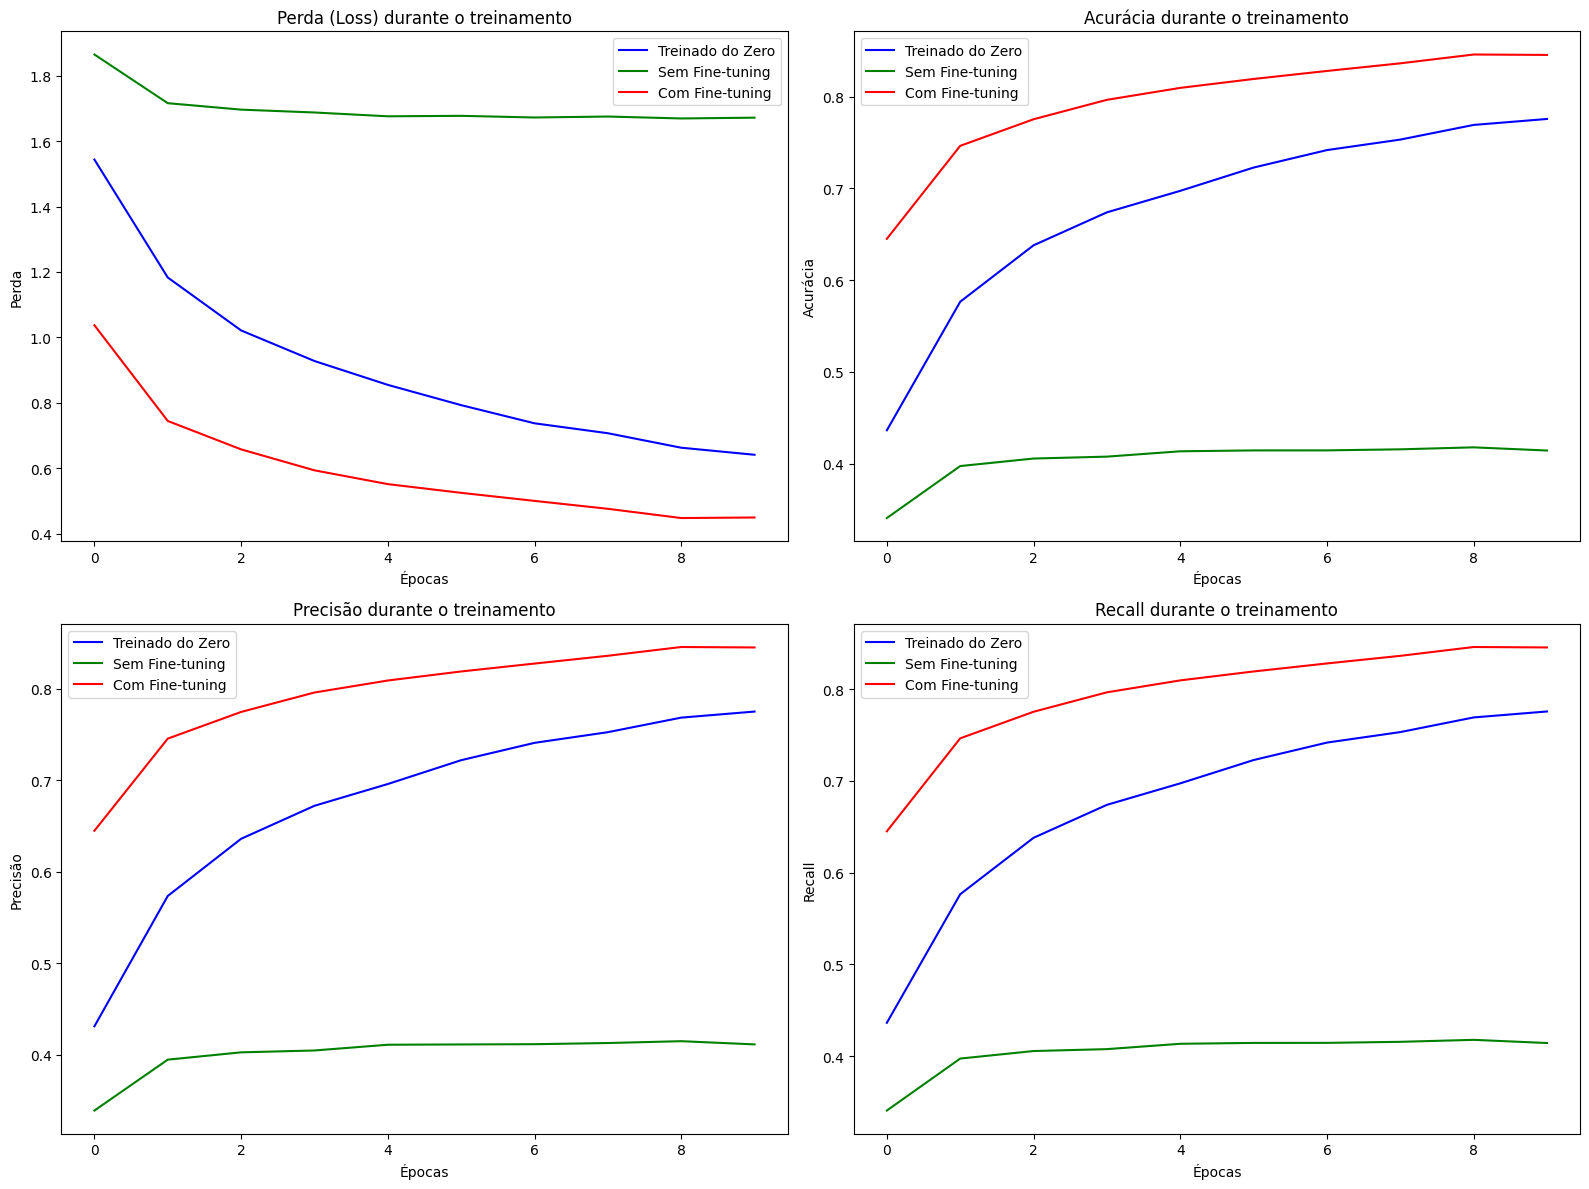

In [21]:
def plot_training_metrics(history_zero, history_no_ft, history_on_ft):
    plt.figure(figsize=(16, 12))
    
    # Plotando a Perda (Loss)
    plt.subplot(2, 2, 1)
    plt.plot(history_zero['train_loss'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['train_loss'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['train_loss'], color='red', label='Com Fine-tuning')
    plt.title('Perda (Loss) durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Plotando a Acurácia
    plt.subplot(2, 2, 2)
    plt.plot(history_zero['accuracy'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['accuracy'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['accuracy'], color='red', label='Com Fine-tuning')
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotando a Precisão (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(history_zero['precision'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['precision'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['precision'], color='red', label='Com Fine-tuning')
    plt.title('Precisão durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Plotando o Recall
    plt.subplot(2, 2, 4)
    plt.plot(history_zero['recall'], color='blue', label='Treinado do Zero')
    plt.plot(history_no_ft['recall'], color='green', label='Sem Fine-tuning')
    plt.plot(history_on_ft['recall'], color='red', label='Com Fine-tuning')
    plt.title('Recall durante o treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    # Ajuste o layout dos gráficos para evitar sobreposição
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()

# Chamando a função para plotar as métricas
plot_training_metrics(history_zero, history_no_ft, history_on_ft)
